In [1]:
from data import get_data
from validation import show_error

data = get_data()
data_train = data[data.index < '2021-12-1']
data_test = data.drop(data_train.index)

In [2]:
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from data import MISO_PREDICTION_COLUMN_NAME, TARGET_NAME

gbr = GradientBoostingRegressor(loss='huber', n_estimators=1000)
X = data_train.drop([MISO_PREDICTION_COLUMN_NAME, TARGET_NAME], axis=1)
y = data_train[TARGET_NAME]

est = gbr.fit(X, y)

X_test = data_test.drop([TARGET_NAME, MISO_PREDICTION_COLUMN_NAME], axis=1)
pred_test = gbr.predict(X_test)
'Prediction ' + show_error(data_test[TARGET_NAME], pred_test)

'Prediction Mean Absolute Error = 760.3507009043349, Max Error = 9002.389162126405, Total Error = 445565.51072993985'

In [3]:
'MTLF ' + show_error(data_test[TARGET_NAME], data_test[MISO_PREDICTION_COLUMN_NAME])

'MTLF Mean Absolute Error = 1055.5164505119458, Max Error = 4932.380000000005, Total Error = 618532.6400000001'

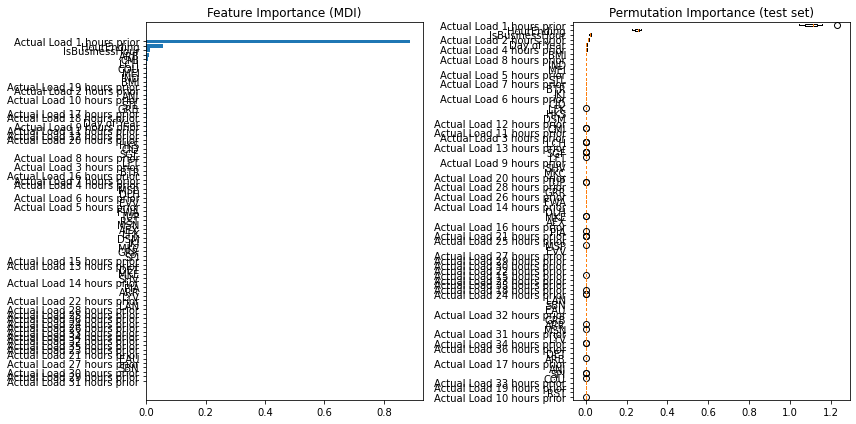

In [4]:
import numpy as np
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    gbr, X_test, data_test[TARGET_NAME], n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [5]:
np.array(data.columns)[sorted_idx]

array(['Actual Load 10 hours prior', 'RST', 'Actual Load 19 hours prior',
       'Actual Load 33 hours prior', 'COU', 'SPI', 'ANJ',
       'Actual Load 17 hours prior', 'ARB', 'DET',
       'Actual Load 36 hours prior', 'Actual Load 34 hours prior', 'LYV',
       'Actual Load 31 hours prior', 'MSN', 'ARR', 'GRB',
       'Actual Load 32 hours prior', 'EAU', 'SBN', 'LAN',
       'Actual Load 24 hours prior', 'Actual Load 18 hours prior',
       'Actual Load 35 hours prior', 'Actual Load 23 hours prior',
       'Actual Load 15 hours prior', 'Actual Load 22 hours prior',
       'Actual Load 30 hours prior', 'Actual Load 29 hours prior',
       'Actual Load 27 hours prior', 'EVV', 'MSP',
       'Actual Load 25 hours prior', 'Actual Load 21 hours prior', 'PIA',
       'Actual Load 16 hours prior', 'AEX', 'MKE', 'DLH',
       'Actual Load 14 hours prior', 'FWA', 'Actual Load 26 hours prior',
       'GRR', 'Actual Load 28 hours prior', 'TUP',
       'Actual Load 20 hours prior', 'MKC', 'SHV',


### HGB using only "Important" Features

In [8]:
num_features = 36
important_features = np.array(data.columns)[sorted_idx][-num_features:]
X = data_train[important_features]
y = data_train[TARGET_NAME]
cats = [n.startswith('Is') for n in X.columns]
hgbr = HistGradientBoostingRegressor(max_iter=1000, categorical_features=cats)
est = hgbr.fit(X, y)

In [9]:
pred_test = hgbr.predict(data_test[important_features])
'Prediction ' + show_error(data_test[TARGET_NAME], pred_test)

'Prediction Mean Absolute Error = 630.2838340132712, Max Error = 6086.793038120566, Total Error = 369346.3267317771'

### Feature Engineering: Relative Discomfort Level

Assume energy use correlates positively with "discomfort".

In [41]:
data_discomfort = data.copy()
important_weather_stations = ['CID', 'MSP', 'GRB', 'DET', 'IND', 'BMI', 'STL', 'MEI', 'SHV', 'LFK']
df = data_discomfort[important_weather_stations]
def discomfort(tmpf, room_temp = 70):
    def clamp(n, min_n, max_n):
        return max(min_n, min(n, max_n))
    val = 0
    if tmpf >= room_temp:
        val = clamp(tmpf - room_temp, 0, 50) / 50
    val = clamp(room_temp - tmpf, 0, 90) / 90
    return round(val, 2)
data_discomfort[important_weather_stations] = df.applymap(discomfort)
#data_discomfort[important_weather_stations] = np.power((df - df.mean())/df.std(), 2) #.apply(abs)#.apply(lambda x: pow(x, 2))
#data_discomfort[important_weather_stations] = np.exp(np.fabs(np.clip(df, -10, a_max=110) - 72)/10)

In [43]:
from data import prior_load_colname
important_hours = [prior_load_colname(i) for i in range(1, 18)]
discomfort_features = important_weather_stations + important_hours + ['IsBusinessHour', 'HourEnding', 'Day of Year']

In [44]:
data_train_discomfort = data_discomfort[data_discomfort.index < '2021-12-1']
data_test_discomfort = data_discomfort.drop(data_train_discomfort.index)

In [45]:
X_discomfort = data_train_discomfort[discomfort_features]
y = data_train[TARGET_NAME]
monotonics = [1 if n in important_weather_stations else 0 for n in X_discomfort.columns]
hgbr = HistGradientBoostingRegressor(max_iter=1000, categorical_features=cats, monotonic_cst=monotonics)
est = gbr.fit(X_discomfort, y)

In [47]:
pred_test = gbr.predict(data_test_discomfort[discomfort_features])
'Prediction ' + show_error(data_test_discomfort[TARGET_NAME], pred_test)

'Prediction Mean Absolute Error = 788.6092390025462, Max Error = 8747.508345038048, Total Error = 462125.014055492'